# 1| Import Dependence

In [11]:
import torch
import torch.nn as nn
from torchinfo import summary
from torchvision import transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.nn import functional as F
from torch import optim

import os
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow

from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix,precision_score,recall_score,roc_curve,auc,accuracy_score
from sklearn.preprocessing import label_binarize

KeyboardInterrupt: 

## Configuration

In [3]:
class Config:
    TRAIN_DIR =  '/Users/anshmadan/Coding/IML Final Project/Birds_25/train'
    VAL_DIR = '/Users/anshmadan/Coding/IML Final Project/Birds_25/valid'
    CLASS_NAME = sorted(os.listdir(TRAIN_DIR))
    N_CLASS = len(CLASS_NAME)
    IMG_SIZE = 224
    BATCH_SIZE = 128
    LR = 0.001
    EPOCHS = 30

## Utilize All GPU For Better Performnace

In [9]:
import torch

if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using MPS (GPU) device")
else:
    device = torch.device('cpu')
    print("Using CPU device")


Using MPS (GPU) device


In [12]:
def Load_Model_to_GPU(model):
    if torch.cuda.device_count() > 1:
        print('Using {} GPUs!'.format(torch.cuda.device_count()))
        
        model = nn.DataParallel(model)
        return model
    else:
        model = model.to(device)
        return model

# 2| Dataset Preparation

In [6]:
transform = T.Compose([
    T.Resize((Config.IMG_SIZE,Config.IMG_SIZE)),
    T.RandomAutocontrast(0.2),
    T.CenterCrop((Config.IMG_SIZE,Config.IMG_SIZE)),
    T.ToTensor()
])

In [16]:
train_dataset = ImageFolder(root=Config.TRAIN_DIR,transform=transform)
val_dataset = ImageFolder(root=Config.VAL_DIR,transform=transform)
train_dataloader = DataLoader(train_dataset,Config.BATCH_SIZE,shuffle=True,num_workers=2)
val_dataloader = DataLoader(val_dataset,Config.BATCH_SIZE,shuffle=True,num_workers=2)

.DS_Store


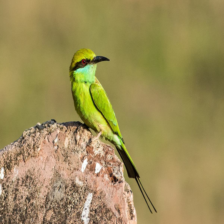

In [17]:
image,labels = train_dataset[2]
print(Config.CLASS_NAME[labels])
T.ToPILImage()(image)

# 3| Modeling (Resnet-50)

In [17]:
class CustomConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size: int, padding: str | int, stride=1, activation=True):
        super(CustomConv, self).__init__()

        self.activation = activation
        self.conv_1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding, stride=stride)
        self.norm = nn.BatchNorm2d(out_channels)
        self.active = nn.ReLU()

    def forward(self, x):
        x = self.conv_1(x)
        x = self.norm(x)

        if self.activation:
            x = self.active(x)
        return x


In [18]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, n_stride=1):
        super(ResidualBlock, self).__init__()

        self.dotted = (n_stride != 1) or (in_channels != out_channels * 4)

        self.conv_1 = CustomConv(in_channels, out_channels, 1, 0, n_stride)
        self.conv_2 = CustomConv(out_channels, out_channels, 3, 'same')
        self.conv_3 = CustomConv(out_channels, out_channels * 4, 1, 'same')

        if self.dotted:
            self.conv_e = CustomConv(in_channels, out_channels * 4, 1, 0, n_stride, activation=False)

    def forward(self, inputs):
        x = self.conv_1(inputs)
        x = self.conv_2(x)
        x = self.conv_3(x)

        if self.dotted:
            x_add = self.conv_e(inputs)
        else:
            x_add = inputs
        
        x_add = x + x_add
        
        return x_add

In [19]:
class ResNet50(nn.Module):
    def __init__(self, N_CLASS):
        super(ResNet50, self).__init__()

        self.conv_7 = CustomConv(3, 64, 7, 3, 2)
        self.max_pool = nn.MaxPool2d(3, 2)

        self.conv_1_1 = ResidualBlock(64, 64)
        self.conv_1_2 = ResidualBlock(256, 64)
        self.conv_1_3 = ResidualBlock(256, 64)
        
        self.dropout_1 = nn.Dropout(0.2)
        
        self.conv_2_1 = ResidualBlock(256, 128, 2)
        self.conv_2_2 = ResidualBlock(512, 128)
        self.conv_2_3 = ResidualBlock(512, 128)
        self.conv_2_4 = ResidualBlock(512, 128)
        
        self.dropout_2 = nn.Dropout(0.2)
        
        self.conv_3_1 = ResidualBlock(512, 256, 2)
        self.conv_3_2 = ResidualBlock(1024, 256)
        self.conv_3_3 = ResidualBlock(1024, 256)
        self.conv_3_4 = ResidualBlock(1024, 256)
        self.conv_3_5 = ResidualBlock(1024, 256)
        self.conv_3_6 = ResidualBlock(1024, 256)
        
        self.dropout_3 = nn.Dropout(0.2)
        
        self.conv_4_1 = ResidualBlock(1024, 512, 2)
        self.conv_4_2 = ResidualBlock(2048, 512)
        self.conv_4_3 = ResidualBlock(2048, 512)
        
        self.dropout_4 = nn.Dropout(0.2)
        
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        
        self.flatten = nn.Flatten()
        
        self.dropout_5 = nn.Dropout(0.2)
        
        self.fc = nn.Linear(2048, N_CLASS)
    
    def forward(self, x):

        x = self.conv_7(x)
        x = self.max_pool(x)

        x = self.conv_1_1(x)
        x = self.conv_1_2(x)
        x = self.conv_1_3(x)
        
        x = self.dropout_1(x)
        
        x = self.conv_2_1(x)
        x = self.conv_2_2(x)
        x = self.conv_2_3(x)
        x = self.conv_2_4(x)
        
        x = self.dropout_2(x)
        
        x = self.conv_3_1(x)
        x = self.conv_3_2(x)
        x = self.conv_3_3(x)
        x = self.conv_3_4(x)
        x = self.conv_3_5(x)
        x = self.conv_3_6(x)

        x = self.dropout_3(x)
        
        x = self.conv_4_1(x)
        x = self.conv_4_2(x)
        x = self.conv_4_3(x)
        
        x = self.dropout_4(x)
        
        x = self.avg_pool(x)
        x = self.flatten(x)
        
        x = self.dropout_5(x)
        
        x = self.fc(x)

        return x

In [20]:
resnet_model = ResNet50(Config.N_CLASS)
resnet_model = Load_Model_to_GPU(resnet_model)
summary(resnet_model,(Config.BATCH_SIZE,3,Config.IMG_SIZE,Config.IMG_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet50                                 [128, 26]                 --
├─CustomConv: 1-1                        [128, 64, 112, 112]       --
│    └─Conv2d: 2-1                       [128, 64, 112, 112]       9,472
│    └─BatchNorm2d: 2-2                  [128, 64, 112, 112]       128
│    └─ReLU: 2-3                         [128, 64, 112, 112]       --
├─MaxPool2d: 1-2                         [128, 64, 55, 55]         --
├─ResidualBlock: 1-3                     [128, 256, 55, 55]        --
│    └─CustomConv: 2-4                   [128, 64, 55, 55]         --
│    │    └─Conv2d: 3-1                  [128, 64, 55, 55]         4,160
│    │    └─BatchNorm2d: 3-2             [128, 64, 55, 55]         128
│    │    └─ReLU: 3-3                    [128, 64, 55, 55]         --
│    └─CustomConv: 2-5                   [128, 64, 55, 55]         --
│    │    └─Conv2d: 3-4                  [128, 64, 55, 55]         36,928
│  

# 4| Train The Model

### For Train

In [21]:
from sklearn import metrics


def train(model,train_loader,optim,loss_fn):
    model.train()
    pbar = tqdm(train_loader)
    
    for batch_size,(image,labels) in enumerate(pbar):
        image, labels = image.to(device), labels.to(device)
        
        optim.zero_grad()
        
        pred = model(image)
        
        loss = loss_fn(pred,labels)
        
        loss.backward()
        optim.step()
        
        prediction = pred.argmax(dim=1)
        
        labels , prediction = labels.to('cpu') , prediction.to('cpu')
        acc = accuracy_score(labels.numpy(),prediction.numpy())
        precision = precision_score(labels.numpy(),prediction.numpy(), average='weighted', zero_division=0)
        recall = recall_score(labels.numpy(),prediction.numpy(), average='weighted', zero_division=0)
        
        pbar.set_description(desc=f'|| Loss = {loss.item():0.4f} || Accuracy = {acc:0.4f} || Precision = {precision:0.4f} || Recall = {recall:0.4f} ||')
    
    metrics['accuracy'].append(acc)
    metrics['loss'].append(loss.item())
    metrics['precision'].append(precision)
    metrics['recall'].append(recall)

### For Validation

In [22]:
def valid(model,val_loader):
    model.eval()
    val_loss = 0 
    with torch.no_grad():
        for image,labels in val_loader:
            
            image , labels = image.to(device),labels.to(device)
            output = model(image)
            
            val_loss += F.cross_entropy(output, labels, reduction='sum').item() 
            pred = output.argmax(dim=1,keepdim=True)
            
            labels , pred = labels.to('cpu') , pred.to('cpu')
            
            acc = accuracy_score(labels.numpy(),pred.numpy())
            precision = precision_score(labels.numpy(),pred.numpy() , average='weighted', zero_division=0)
            recall = recall_score(labels.numpy(),pred.numpy(), average='weighted', zero_division=0)
            
    val_loss /= len(val_loader.dataset)
    
    metrics['val_accuracy'].append(acc)
    metrics['val_loss'].append(val_loss)
    metrics['val_precision'].append(precision)
    metrics['val_recall'].append(recall)
    
    print(f'|| Validation Loss = {val_loss:0.4f} || Validation Accuracy = {acc:0.4f} || Validation Precision = {precision:0.4f} || Validation Recall = {recall:0.4f} ||')

 ## Optimizer and Loss 

In [23]:
resnet_optim = optim.NAdam(resnet_model.parameters(),lr=Config.LR)

In [24]:
loss_fn = nn.CrossEntropyLoss()

In [25]:
metrics = {'accuracy':[],'val_accuracy':[],
           'loss':[],'val_loss':[],
           'precision':[],'val_precision':[],
           'recall':[],'val_recall':[]}

In [26]:
for epoch in range(Config.EPOCHS):
    print(f'|| Epoch : [{epoch+1}/{Config.EPOCHS}] ||')
    train(resnet_model,train_dataloader,resnet_optim,loss_fn)
    valid(resnet_model,val_dataloader)

|| Epoch : [1/30] ||


|| Loss = 2.5552 || Accuracy = 0.1719 || Precision = 0.3295 || Recall = 0.1719 ||:  33%|███▎      | 78/235 [33:29<1:07:25, 25.77s/it]


KeyboardInterrupt: 

# 5| Check The Performance

## Plot Accuracy and Loss

In [1]:
def plot_graph(ax, metrics1: list, metrics2: list, label: str) -> None:
    ax.plot(range(1, len(metrics1) + 1), metrics1, label=f'Training {label}', color='green',marker='')
    ax.plot(range(1, len(metrics2) + 1), metrics2, label=f'Validation {label}', color='red',marker='')
    ax.set_xlabel('Epochs')
    ax.set_ylabel(f'{label}')
    ax.set_title(f'Training and validation {label}')
    ax.legend()
    ax.grid(True)
    

NameError: name 'plot_graph' is not defined

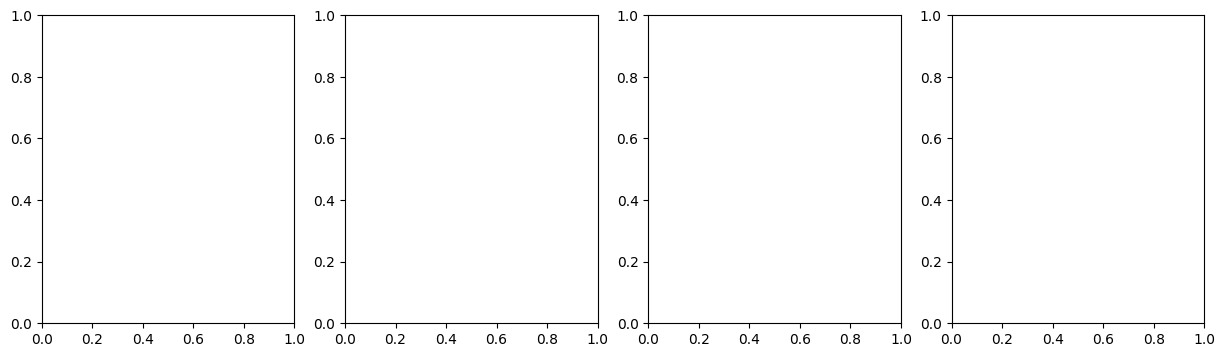

In [8]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 4))

# accuracy
plot_graph(ax1, metrics['accuracy'], metrics['val_accuracy'], 'accuracy')

# loss
plot_graph(ax2, metrics['loss'], metrics['val_loss'], 'loss')

# precision
plot_graph(ax3, metrics['precision'], metrics['val_precision'], 'precision')

# recall
plot_graph(ax4, metrics['recall'], metrics['val_recall'], 'recall')

fig.suptitle('Training and validation metrics', fontsize=20)

plt.tight_layout()
plt.subplots_adjust(top=0.8)

plt.show()

In [7]:
df = {
    'train_acc':metrics['accuracy'],
    'val_acc':metrics['val_accuracy'],
    'loss':metrics['loss'],
    'val_loss':metrics['val_loss'],
    'precision':metrics['precision'],
    'val_precision':metrics['precision'],
    'recall':metrics['recall'],
    'val_recall':metrics['val_recall']
}
pd.DataFrame(df)

TypeError: 'module' object is not subscriptable

### Get the Prediction

In [ ]:
def get_preds(model, dataloader):
    preds, labels = [], []
    model.eval()
    with torch.no_grad():
        for image, label in dataloader:
            image, label = image.to(device), label.to(device)

            pred = model(image)
            pred = pred.argmax(dim=1)
            
            preds.extend(pred.cpu().numpy().tolist())
            labels.extend(label.cpu().numpy().tolist())
    return preds, labels

preds, labels = get_preds(resnet_model, val_dataloader)

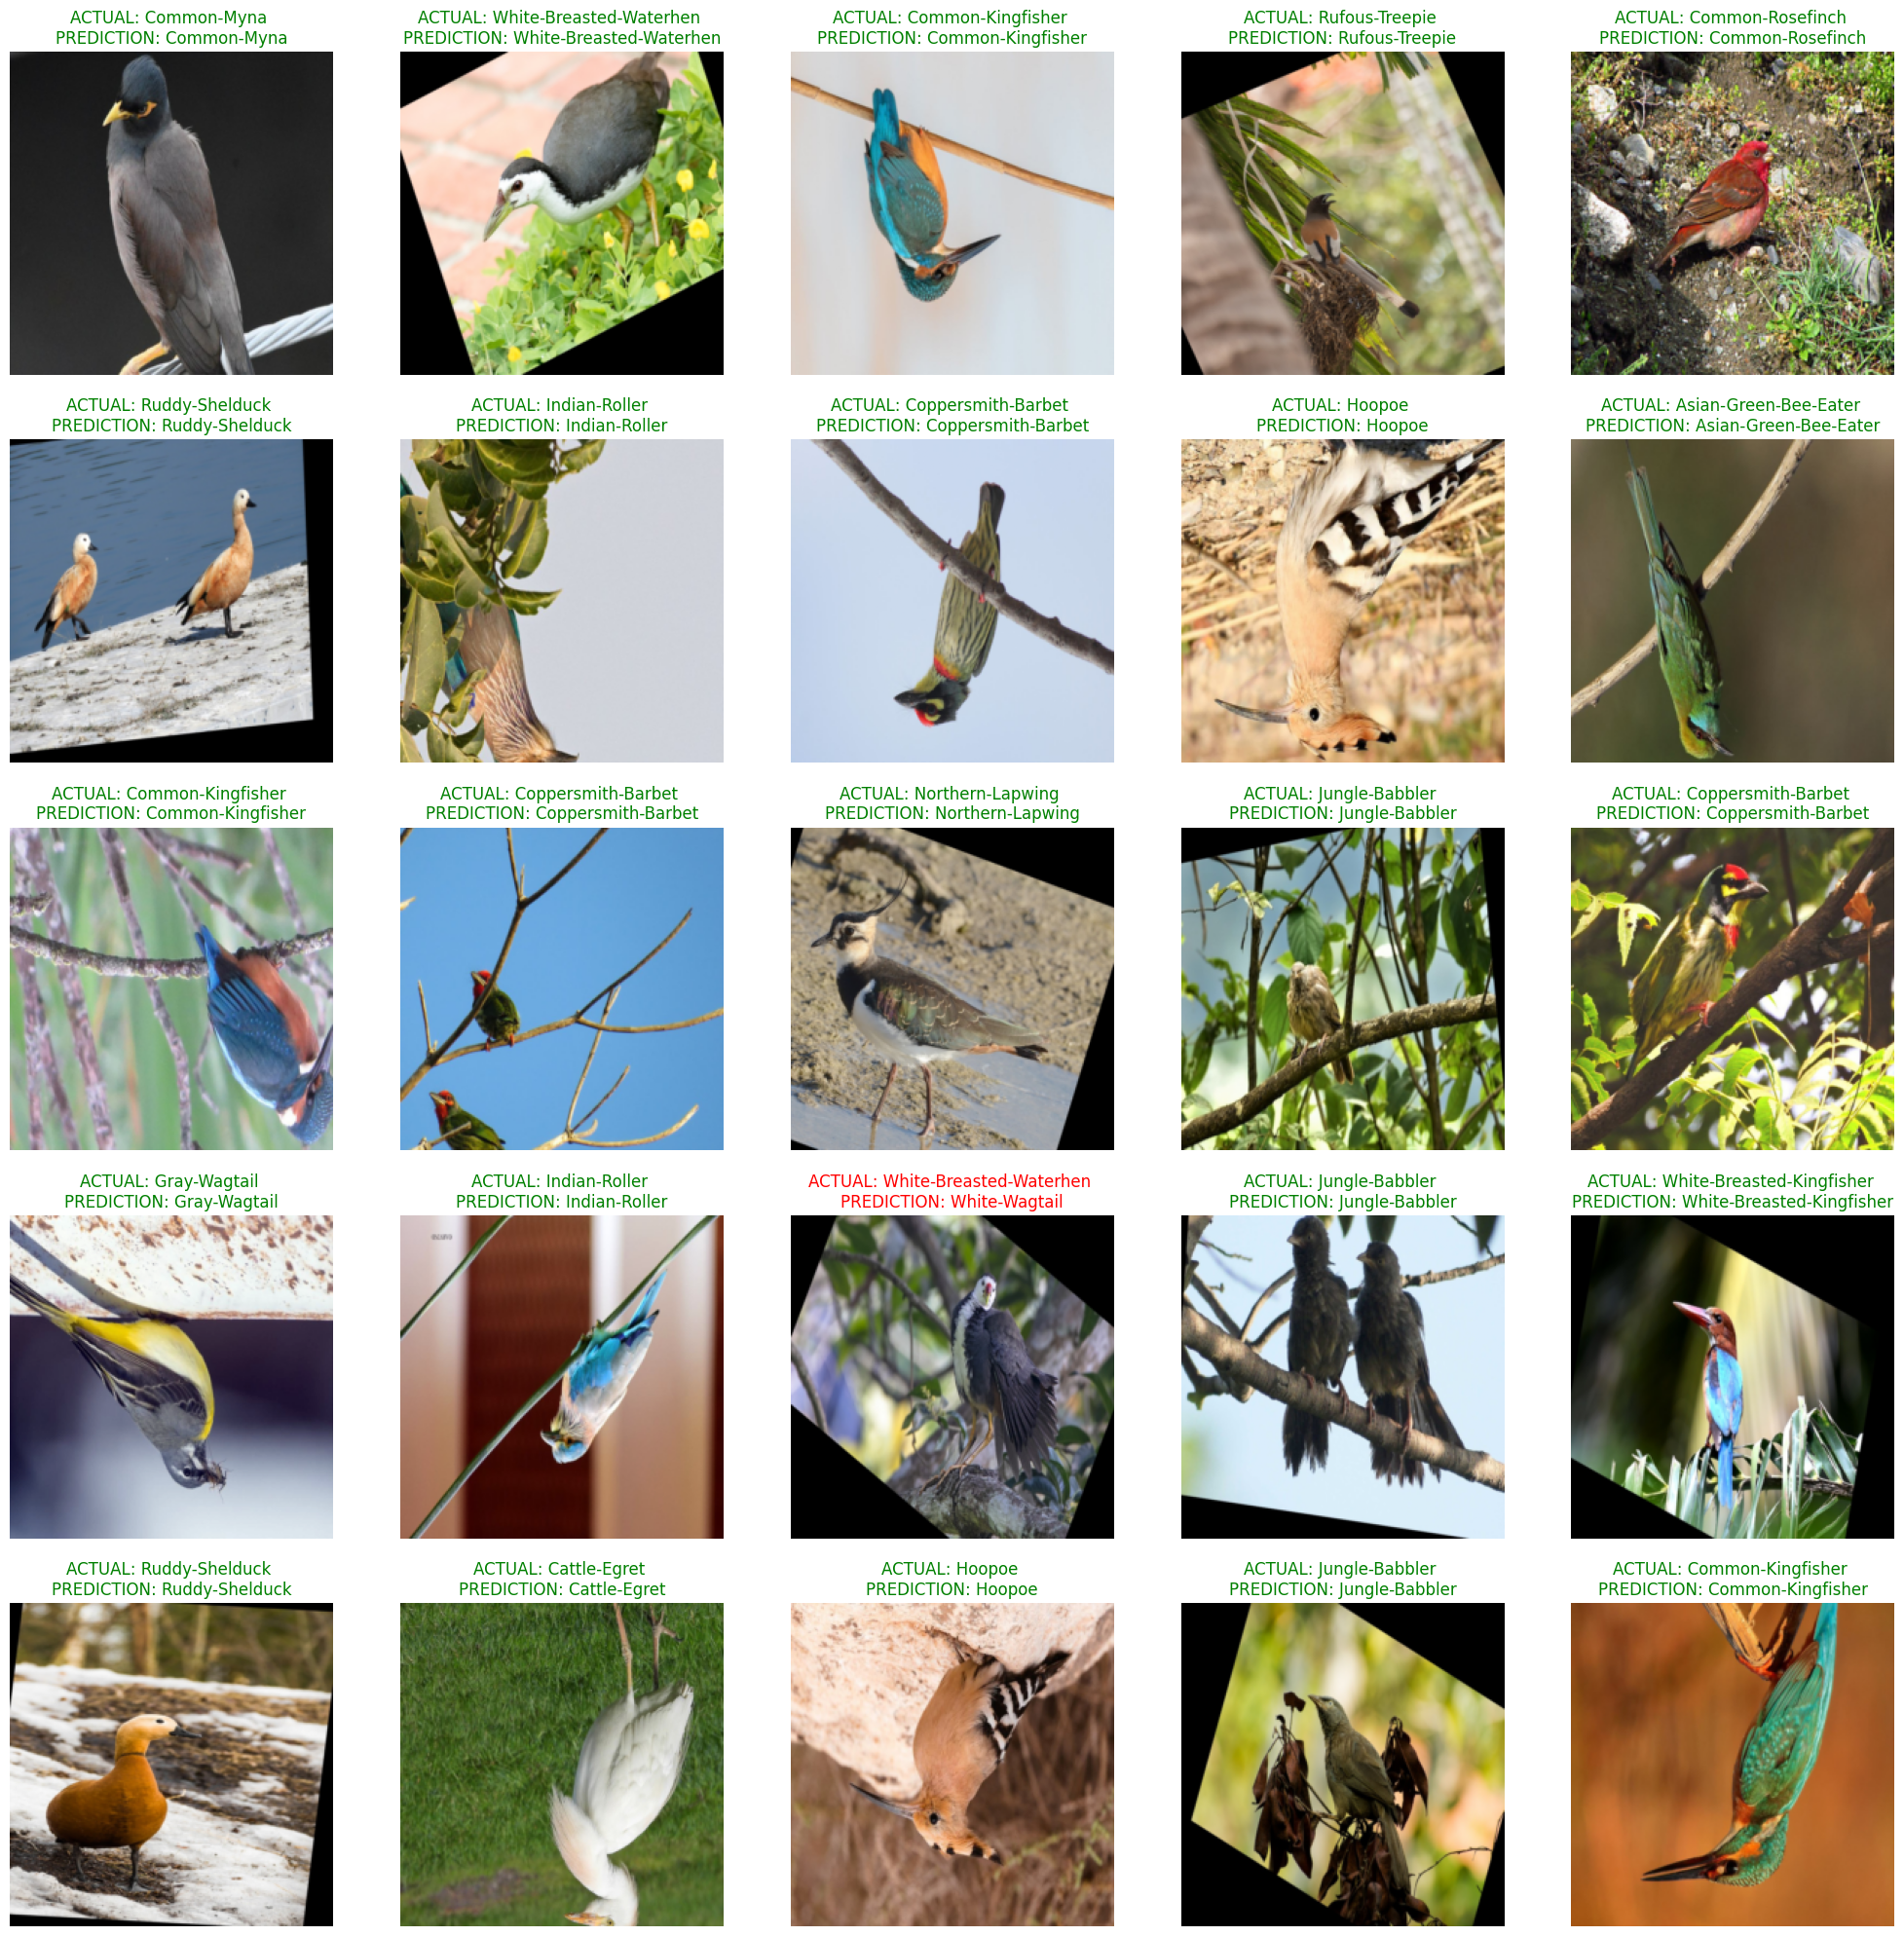

In [72]:
def show_prediction(model, dataloader):
    images,labels,preds = [],[],[]
    with torch.no_grad():
        for image,label in dataloader:
            image,label = image.to(device),label.to(device)
            
            pred = model(image).argmax(dim=1)
            
            images.append(image.cpu())
            labels.append(label.cpu().numpy().tolist())
            preds.append(pred.cpu().numpy().tolist())
            break
    fig , ax = plt.subplots(5,5,figsize=(25,25))
    ax = ax.flatten()
    images,labels,preds = images[0],labels[0],preds[0]
    for i in range(25):
        ax[i].imshow(images[i].permute(1, 2, 0))  
        color = 'green' if labels[i] == preds[i] else 'red'
        ax[i].set_title(
            f'ACTUAL: {Config.CLASS_NAME[labels[i]]} \nPREDICTION: {Config.CLASS_NAME[preds[i]]}',
            color=color
        )
        ax[i].axis('off') 
    plt.show()

show_prediction(resnet_model,val_dataloader)

## ROC Curve

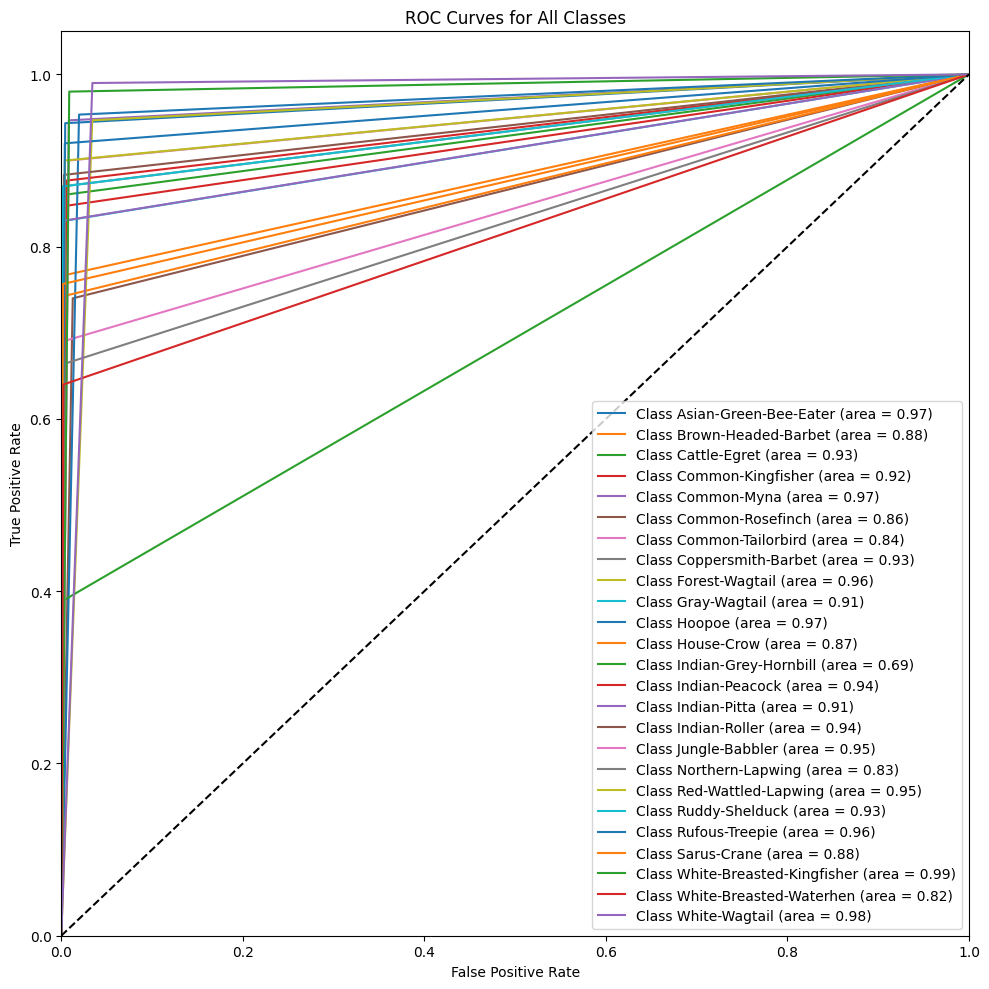

In [ ]:
labels_binarized = label_binarize(labels, classes=[i for i in range(num_classes)])

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(labels_binarized[:, i], np.array(preds) == i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 10))

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {Config.CLASS_NAME[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Classes')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

## Confusion Matrix

<Axes: title={'center': 'Confusion Matrix'}>

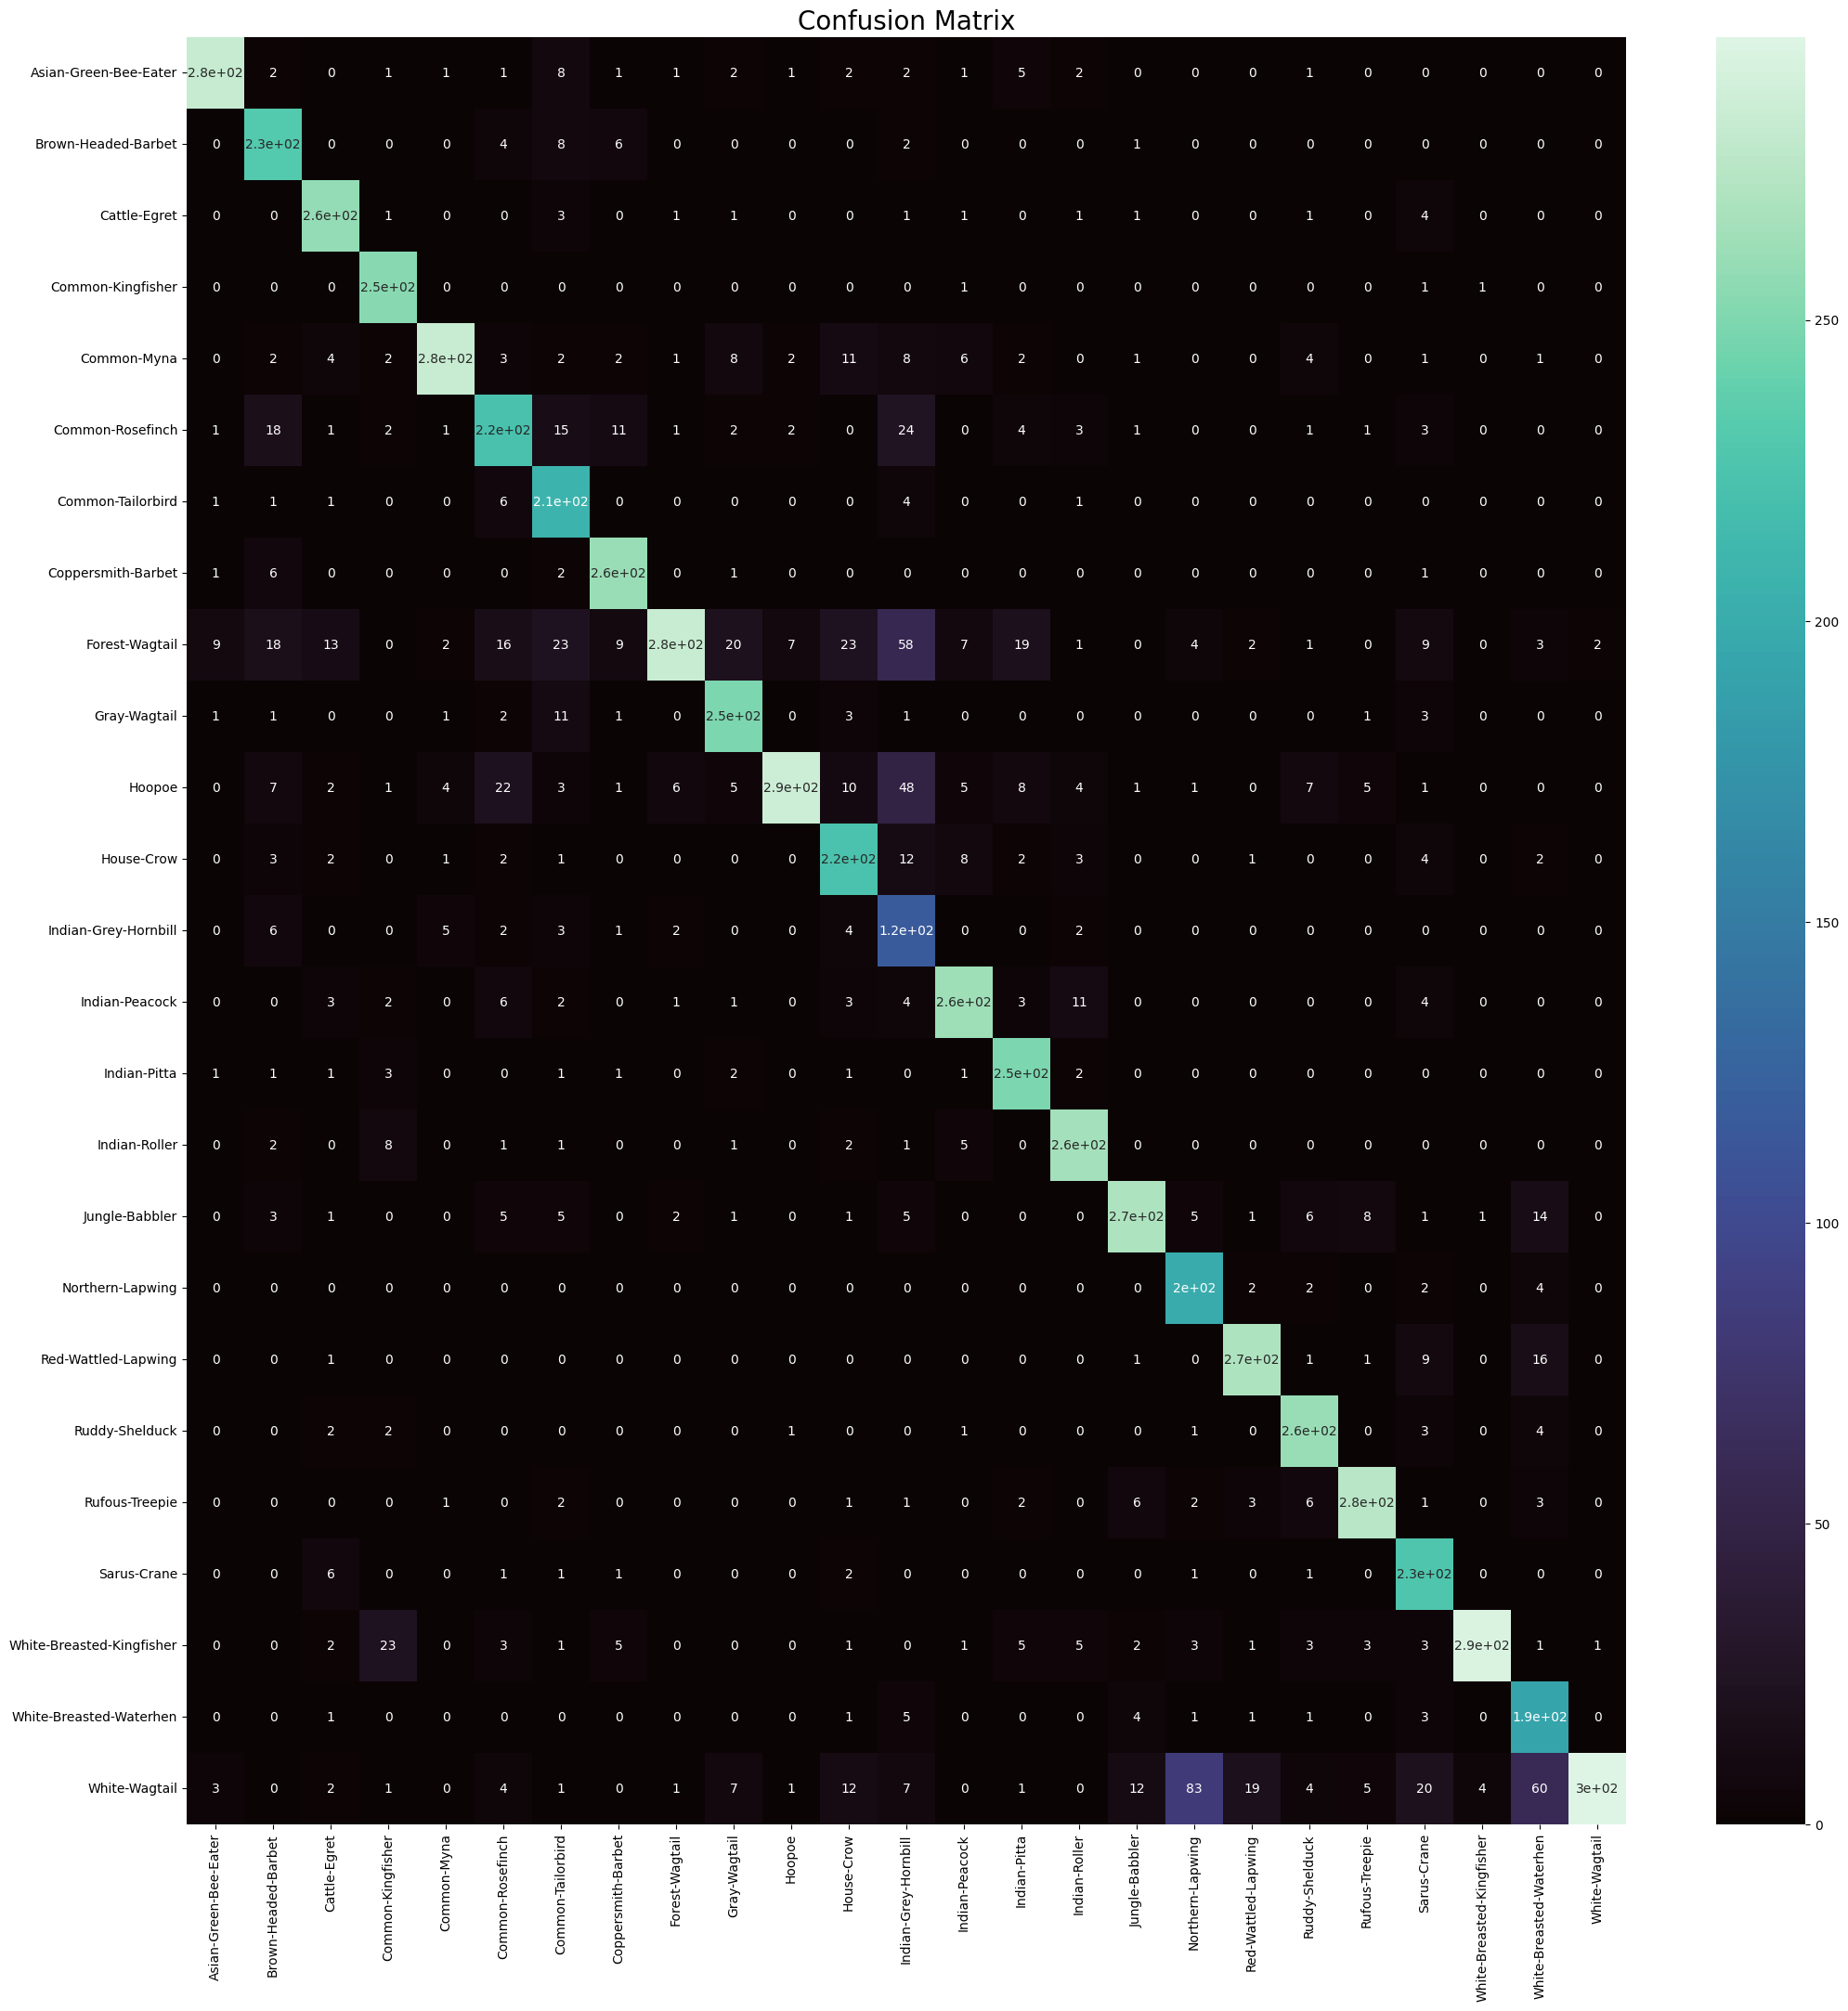

In [ ]:
cm = confusion_matrix(preds, labels)  
df_cm = pd.DataFrame(cm,index = Config.CLASS_NAME , columns = Config.CLASS_NAME)
plt.figure(figsize=(25,25))
plt.title('Confusion Matrix',fontsize=20)
cmap = sns.color_palette("mako", as_cmap=True)
sns.heatmap(df_cm,annot=True,cmap=cmap)